# Project Overview and Importing the libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plot_utils
from tqdm import tqdm
from tqdm.notebook import tqdm
from IPython import display
print("Tensorflow version: "+ tf.__version__)

Tensorflow version: 2.2.0


# Load and Preprocess the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

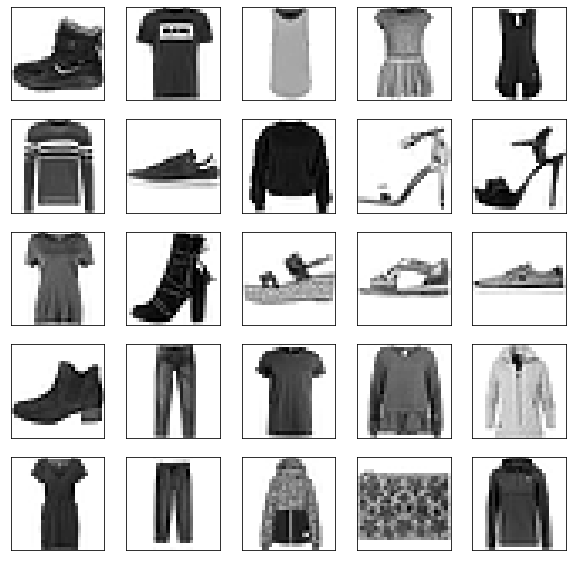

In [4]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

# Create batches of training data

In [6]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

# Build the Generator network for DCGAN

In [7]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding = 'same', activation = 'tanh'),
])

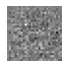

In [8]:
noise = tf.random.normal(shape = [1, num_features])
generated_image = generator(noise, training = False)
plot_utils.show(generated_image)

# Build the Discriminator Network for DCGAN

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding = 'same', input_shape = [28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [12]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49699986]], shape=(1, 1), dtype=float32)


# compile the Deep Convolutional Generative Adversarial Network(DCGAN)

In [13]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

gan = keras.models.Sequential([
    generator, 
    discriminator
])

gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

# Define Training Procedure 

In [14]:
seed = tf.random.normal(shape = [batch_size, num_features])

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch+1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait = True)
    generate_and_save_iamges(generator, epochs, seed)

# Train DCGAN

In [19]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

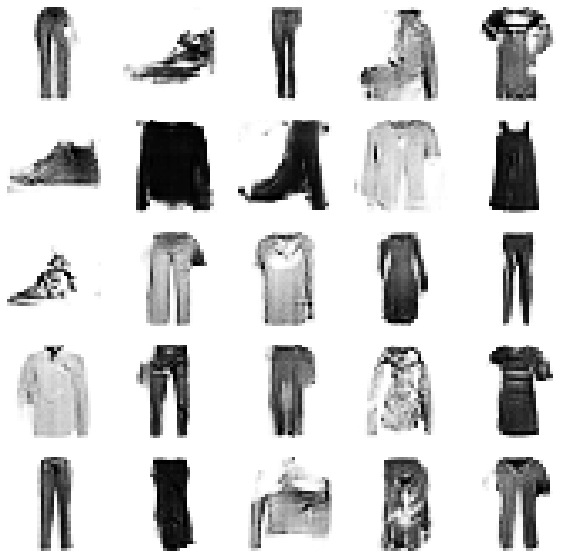

TypeError: clear_output() got an unexpected keyword argument 'wati'

In [22]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)

# Generated Synthetic Images with DCGAN

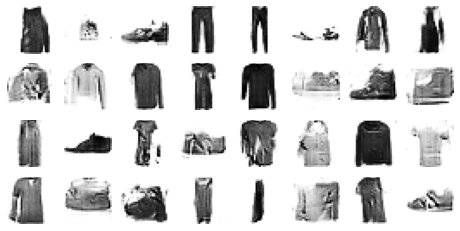

In [23]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)

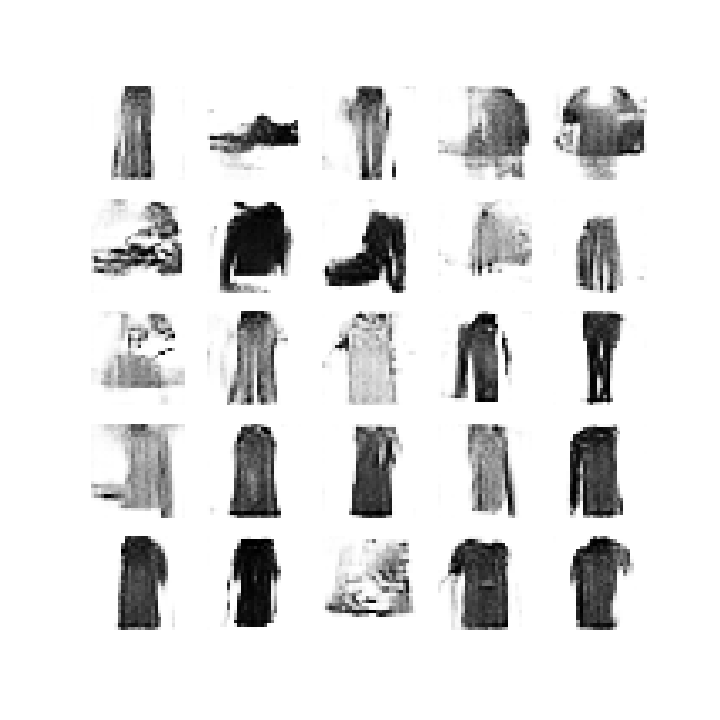

In [24]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)